# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 1024
device = 'cuda:1'
mixup = True
MOD="resnet20"

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
#import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

DATA_DIR = "cifar100/"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("cifar100/train.csv")
val_df = pd.read_csv("cifar100/test.csv")
train_df

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,19_11_100000.jpg,cattle,19,large_omnivores_and_herbivores,11
1,29_15_100001.jpg,dinosaur,29,reptiles,15
2,0_4_100002.jpg,apple,0,fruit_and_vegetables,4
3,11_14_100003.jpg,boy,11,people,14
4,1_1_100004.jpg,aquarium_fish,1,fish,1
...,...,...,...,...,...
49995,80_16_149995.jpg,squirrel,80,small_mammals,16
49996,7_7_149996.jpg,beetle,7,insects,7
49997,3_8_149997.jpg,bear,3,large_carnivores,8
49998,7_7_149998.jpg,beetle,7,insects,7


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        images = cv2.imread(os.path.join(DATA_DIR, img_id))
        
        # Load labels
        label = row.fine_labels
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

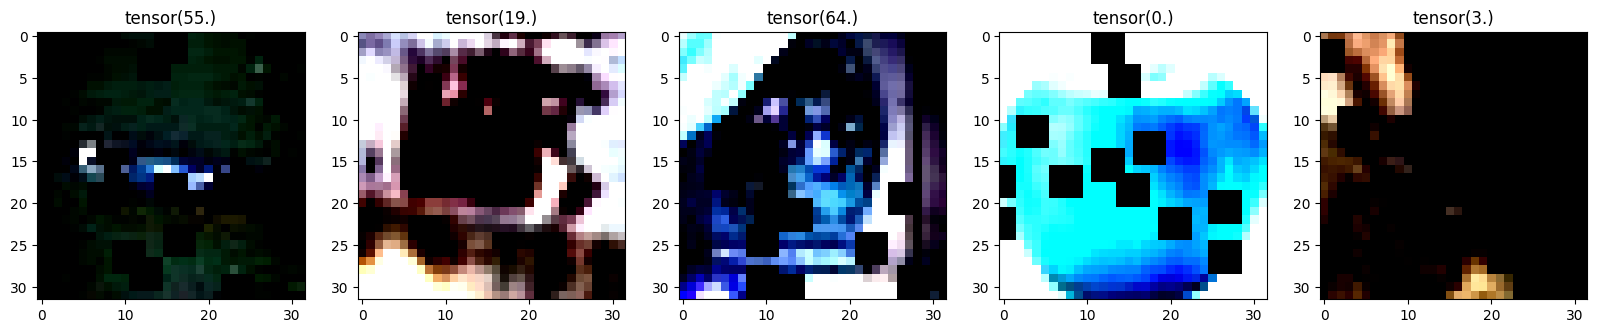

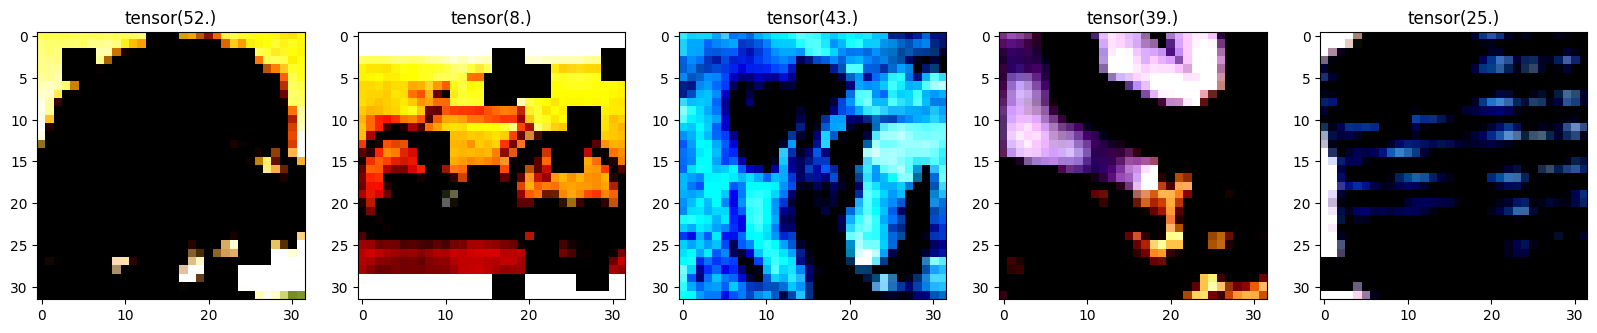

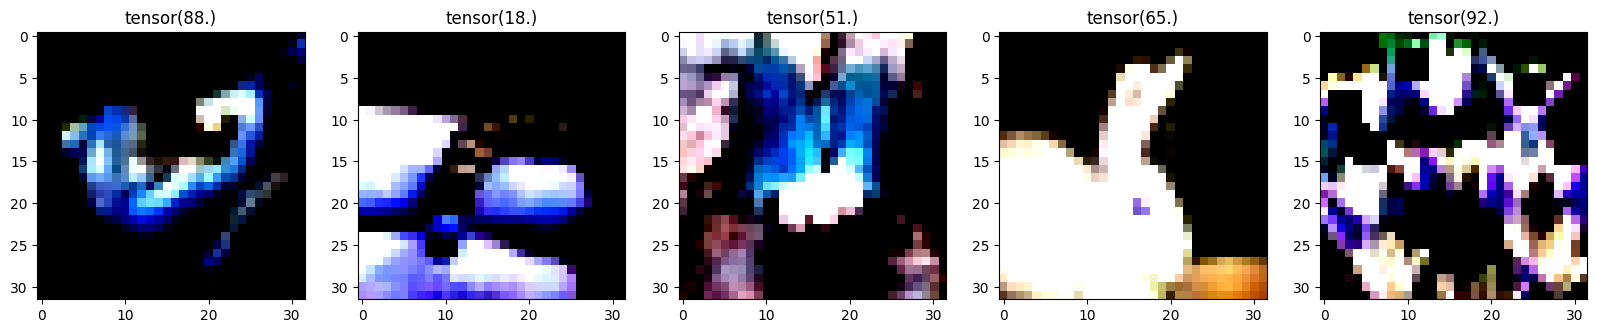

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [38]:
from mixup import mixup, mixup_cross_entropy_loss


def train(train_loader, model, optimizer, epoch):
    """
        Run one train epoch
    """
    criterion = mixup_cross_entropy_loss
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)

        if not mixup:
          alpha = 0
        else:
          alpha = 1
          input_var, target_var = mixup(input, target.long(), 100)
        
        input_var = input_var.to(device)
        target_var = target_var.to(device)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))
        top1 = 0

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg

def validate(val_loader, model):
    """
    Run evaluation
    """
    criterion = nn.CrossEntropyLoss()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().to(device)
            input_var = input.to(device)
            target_var = target.to(device)

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [39]:
train_dataset = cifarDataset(train_df, transform=transforms_train)
val_dataset = cifarDataset(val_df, transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from pact_utils import QuantizedLinear, QuantizedConv2d, PGConv2d


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = QuantizedConv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, wbits=k, abits=k)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = QuantizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, wbits=k, abits=k)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    QuantizedConv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False, wbits=k, abits=k),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # Relu is implemented as the input of conv2d
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.k = K

        self.conv1 = QuantizedConv2d(3, self.in_planes, kernel_size=3, stride=2, padding=1, bias=False, abits=8, wbits=8)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.layer1 = self._make_layer(block, self.in_planes, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, self.in_planes*2, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, self.in_planes*4, num_blocks[2], stride=2, expansion=1)
        self.layer4 = self._make_layer(block, self.in_planes*2, num_blocks[3], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = QuantizedLinear(self.in_planes, num_classes, abits=8, wbits=8)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [2, 2, 2, 2], K=k, num_classes=100)

def resnet34(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 4, 6, 3], K=k, num_classes=100)

In [41]:
net = resnet20(8)

bit width: 8


In [42]:
net

ResNet(
  (conv1): QuantizedConv2d(
    3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
    (quantize_w): TorchQuantize(
      (quantize): TorchRoundToBits()
    )
    (quantize_a): TorchQuantize(
      (quantize): TorchRoundToBits()
    )
  )
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): QuantizedConv2d(
        32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (quantize_w): TorchQuantize(
          (quantize): TorchRoundToBits()
        )
        (quantize_a): TorchQuantize(
          (quantize): TorchRoundToBits()
        )
      )
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): QuantizedConv2d(
        32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (quantize_w): TorchQuantize(
          (quantize): TorchRoundToBits()
        )
        (quantiz

# Train with quantization

In [ ]:
from timm.scheduler import CosineLRScheduler

for k in range(6,9):
    if MOD == "resnet18" or MOD=="resnet20":
        net = resnet20(k=k)
    elif MOD=="resnet34":
        net = resnet34(k=k)

    model = net.to(device)

    # Track experiment with wandb
    import wandb
    watermark = "{}_quantize_k{}_cifar100_original".format(MOD, k)
    if mixup:
        watermark += "_mixup"

    # mess with wandb
    wandb.init(project="quantize_resnet_cifar100", name=watermark)

    # optimizer for pact
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

bit width: 6


current lr 1.00000e-06


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.533 (0.533)	Loss 5.6234 (5.6234)	Prec@1 1.465 (1.465)
 * Prec@1 0.930
alpha1 9.999953269958496
Best prec1 :  0.9299999993324279
current lr 3.34000e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.562 (0.562)	Loss 3.9808 (3.9808)	Prec@1 11.133 (11.133)
 * Prec@1 10.040
alpha1 9.983597755432129
Best prec1 :  10.040000016784669
current lr 6.67000e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.521 (0.521)	Loss 3.7539 (3.7539)	Prec@1 14.648 (14.648)
 * Prec@1 13.390
alpha1 9.950971603393555
Best prec1 :  13.389999961853027
current lr 1.00000e-03


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.479 (0.479)	Loss 3.6863 (3.6863)	Prec@1 14.551 (14.551)
 * Prec@1 14.740
alpha1 9.902182579040527
Best prec1 :  14.740000006103516
current lr 9.99938e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.502 (0.502)	Loss 3.4055 (3.4055)	Prec@1 17.676 (17.676)
 * Prec@1 18.240
alpha1 9.853543281555176
Best prec1 :  18.240000009155274
current lr 9.99754e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.537 (0.537)	Loss 3.3337 (3.3337)	Prec@1 20.020 (20.020)
 * Prec@1 20.960
alpha1 9.805047035217285
Best prec1 :  20.95999996948242
current lr 9.99445e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.519 (0.519)	Loss 3.3050 (3.3050)	Prec@1 19.922 (19.922)
 * Prec@1 20.080
alpha1 9.75669002532959
Best prec1 :  20.95999996948242
current lr 9.99014e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.482 (0.482)	Loss 3.1420 (3.1420)	Prec@1 25.098 (25.098)
 * Prec@1 23.080
alpha1 9.708473205566406
Best prec1 :  23.07999992675781
current lr 9.98460e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.500 (0.500)	Loss 3.0679 (3.0679)	Prec@1 25.098 (25.098)
 * Prec@1 25.170
alpha1 9.660398483276367
Best prec1 :  25.170000009155274
current lr 9.97783e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.460 (0.460)	Loss 3.0782 (3.0782)	Prec@1 26.074 (26.074)
 * Prec@1 24.630
alpha1 9.612466812133789
Best prec1 :  25.170000009155274
current lr 9.96983e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.482 (0.482)	Loss 2.9588 (2.9588)	Prec@1 29.785 (29.785)
 * Prec@1 27.380
alpha1 9.564682960510254
Best prec1 :  27.380000021362303
current lr 9.96061e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.460 (0.460)	Loss 2.8878 (2.8878)	Prec@1 28.906 (28.906)
 * Prec@1 28.270
alpha1 9.517050743103027
Best prec1 :  28.270000048828123
current lr 9.95017e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.488 (0.488)	Loss 2.8587 (2.8587)	Prec@1 29.688 (29.688)
 * Prec@1 28.630
alpha1 9.46957015991211
Best prec1 :  28.629999978637695
current lr 9.93850e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.487 (0.487)	Loss 2.8927 (2.8927)	Prec@1 28.125 (28.125)
 * Prec@1 28.610
alpha1 9.422245979309082
Best prec1 :  28.629999978637695
current lr 9.92562e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.505 (0.505)	Loss 2.8288 (2.8288)	Prec@1 31.250 (31.250)
 * Prec@1 28.990
alpha1 9.375082015991211
Best prec1 :  28.98999994506836
current lr 9.91152e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.521 (0.521)	Loss 2.7557 (2.7557)	Prec@1 31.641 (31.641)
 * Prec@1 32.000
alpha1 9.328080177307129
Best prec1 :  32.00000000915527
current lr 9.89622e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.522 (0.522)	Loss 2.6809 (2.6809)	Prec@1 33.594 (33.594)
 * Prec@1 32.890
alpha1 9.281245231628418
Best prec1 :  32.88999987182617
current lr 9.87970e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.531 (0.531)	Loss 2.7343 (2.7343)	Prec@1 33.594 (33.594)
 * Prec@1 32.480
alpha1 9.234580993652344
Best prec1 :  32.88999987182617
current lr 9.86199e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.464 (0.464)	Loss 2.5990 (2.5990)	Prec@1 34.668 (34.668)
 * Prec@1 34.530
alpha1 9.188089370727539
Best prec1 :  34.53000010375977
current lr 9.84307e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.512 (0.512)	Loss 2.6739 (2.6739)	Prec@1 34.082 (34.082)
 * Prec@1 33.340
alpha1 9.141775131225586
Best prec1 :  34.53000010375977
current lr 9.82296e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.535 (0.535)	Loss 2.5697 (2.5697)	Prec@1 36.523 (36.523)
 * Prec@1 34.640
alpha1 9.095640182495117
Best prec1 :  34.6399998840332
current lr 9.80167e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.555 (0.555)	Loss 2.6013 (2.6013)	Prec@1 35.254 (35.254)
 * Prec@1 34.820
alpha1 9.049688339233398
Best prec1 :  34.82000004882813
current lr 9.77919e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.486 (0.486)	Loss 2.5080 (2.5080)	Prec@1 37.305 (37.305)
 * Prec@1 36.090
alpha1 9.003924369812012
Best prec1 :  36.0900000793457
current lr 9.75553e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.468 (0.468)	Loss 2.4792 (2.4792)	Prec@1 38.379 (38.379)
 * Prec@1 37.700
alpha1 8.958351135253906
Best prec1 :  37.69999993286133
current lr 9.73070e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.520 (0.520)	Loss 2.4352 (2.4352)	Prec@1 38.965 (38.965)
 * Prec@1 38.200
alpha1 8.91297435760498
Best prec1 :  38.19999983520508
current lr 9.70470e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.479 (0.479)	Loss 2.4999 (2.4999)	Prec@1 36.328 (36.328)
 * Prec@1 35.880
alpha1 8.867796897888184
Best prec1 :  38.19999983520508
current lr 9.67754e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.538 (0.538)	Loss 2.4107 (2.4107)	Prec@1 39.258 (39.258)
 * Prec@1 38.520
alpha1 8.822818756103516
Best prec1 :  38.51999985351563
current lr 9.64923e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.549 (0.549)	Loss 2.3847 (2.3847)	Prec@1 39.551 (39.551)
 * Prec@1 38.750
alpha1 8.778043746948242
Best prec1 :  38.74999999389649
current lr 9.61978e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.501 (0.501)	Loss 2.4250 (2.4250)	Prec@1 39.648 (39.648)
 * Prec@1 39.010
alpha1 8.733481407165527
Best prec1 :  39.00999994506836
current lr 9.58918e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.511 (0.511)	Loss 2.4038 (2.4038)	Prec@1 39.746 (39.746)
 * Prec@1 39.350
alpha1 8.68912410736084
Best prec1 :  39.35000001220703
current lr 9.55746e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.530 (0.530)	Loss 2.3086 (2.3086)	Prec@1 40.723 (40.723)
 * Prec@1 40.560
alpha1 8.64498519897461
Best prec1 :  40.55999993896484
current lr 9.52461e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.584 (0.584)	Loss 2.3330 (2.3330)	Prec@1 39.258 (39.258)
 * Prec@1 40.040
alpha1 8.60106372833252
Best prec1 :  40.55999993896484
current lr 9.49065e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.504 (0.504)	Loss 2.2896 (2.2896)	Prec@1 42.773 (42.773)
 * Prec@1 41.110
alpha1 8.557357788085938
Best prec1 :  41.109999963378904
current lr 9.45558e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.488 (0.488)	Loss 2.3507 (2.3507)	Prec@1 40.723 (40.723)
 * Prec@1 40.430
alpha1 8.513877868652344
Best prec1 :  41.109999963378904
current lr 9.41941e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.514 (0.514)	Loss 2.2581 (2.2581)	Prec@1 42.773 (42.773)
 * Prec@1 42.230
alpha1 8.470626831054688
Best prec1 :  42.22999992675781
current lr 9.38215e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.519 (0.519)	Loss 2.2628 (2.2628)	Prec@1 42.188 (42.188)
 * Prec@1 41.810
alpha1 8.427605628967285
Best prec1 :  42.22999992675781
current lr 9.34381e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.532 (0.532)	Loss 2.2810 (2.2810)	Prec@1 42.090 (42.090)
 * Prec@1 42.080
alpha1 8.384818077087402
Best prec1 :  42.22999992675781
current lr 9.30441e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.505 (0.505)	Loss 2.2311 (2.2311)	Prec@1 42.871 (42.871)
 * Prec@1 43.390
alpha1 8.342265129089355
Best prec1 :  43.389999896240234
current lr 9.26394e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.533 (0.533)	Loss 2.1695 (2.1695)	Prec@1 45.215 (45.215)
 * Prec@1 43.550
alpha1 8.29995059967041
Best prec1 :  43.54999995727539
current lr 9.22242e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.532 (0.532)	Loss 2.1737 (2.1737)	Prec@1 45.117 (45.117)
 * Prec@1 43.390
alpha1 8.257877349853516
Best prec1 :  43.54999995727539
current lr 9.17986e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.498 (0.498)	Loss 2.2128 (2.2128)	Prec@1 43.848 (43.848)
 * Prec@1 43.120
alpha1 8.216047286987305
Best prec1 :  43.54999995727539
current lr 9.13627e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.549 (0.549)	Loss 2.1965 (2.1965)	Prec@1 43.848 (43.848)
 * Prec@1 43.290
alpha1 8.174466133117676
Best prec1 :  43.54999995727539
current lr 9.09166e-04


  0%|          | 0/49 [00:00<?, ?it/s]

Test: [0/10]	Time 0.476 (0.476)	Loss 2.1711 (2.1711)	Prec@1 45.312 (45.312)
 * Prec@1 44.360
alpha1 8.133134841918945
Best prec1 :  44.36000007324219
current lr 9.04604e-04


  0%|          | 0/49 [00:00<?, ?it/s]